In [17]:
pwd

'/Users/jbloom/Classes/python-seminar/Lectures/11_Cython'

In [16]:
%run ../../DataFiles_and_Notebooks/00_AdvancedPythonConcepts/talktools.py

https://bids.berkeley.edu/news/join-us-2018-bids-data-science-faire-may-8

http://news.berkeley.edu/2013/12/13/big-turnout-for-launch-of-big-data-center/

<img src="https://bids.berkeley.edu/sites/default/files/bids-dsf-collage_1.png">

<img src="https://www.evernote.com/shard/s325/sh/12293011-1c74-48c1-ad30-b97b84471174/be5157621bc19944/res/49d51345-ac21-4793-99f7-a26e551c79d6/skitch.png">

# Making Python Faster

<img src="slides/warp1.jpg">


<h2> ... and using legacy code</h2>

- we've already seen `numexpr`, parallelization, etc.

- Python is _slow_ ... it's interpreted on the fly

- no static typing ... even integers are objects (bulky memory!)

- what if we want to write Python, but use it as a *glue* to fast C-code?

<pre>
Premature optimization is the root of all evil 
   -- Donald Knuth
</pre>

<pre>
C is premature optimization
   -- Kanye West
</pre>


## Profiling ##

You already know that Python comes with batteries include, and performance profiling is no exception.

You can keep track of how much time each *function* is taking up using tools from the standard library.

Here's the [documentation of `profile` and `cProfile`](http://docs.python.org/3/library/profile.html), but you probably won't need to use them directly.  A profile is a set of statistics that describes how often and for how long various parts of the program executed. These statistics can be formatted into reports via the pstats module.

In [18]:
import cProfile
import re
cProfile.run('re.compile("fizz|buzz")') # run a piece of code

         217 function calls (212 primitive calls) in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        4    0.000    0.000    0.000    0.000 enum.py:265(__call__)
        4    0.000    0.000    0.000    0.000 enum.py:515(__new__)
        2    0.000    0.000    0.000    0.000 enum.py:801(__and__)
        1    0.000    0.000    0.000    0.000 re.py:231(compile)
        1    0.000    0.000    0.000    0.000 re.py:286(_compile)
        1    0.000    0.000    0.000    0.000 sre_compile.py:223(_compile_charset)
        1    0.000    0.000    0.000    0.000 sre_compile.py:250(_optimize_charset)
        1    0.000    0.000    0.000    0.000 sre_compile.py:414(_get_literal_prefix)
        1    0.000    0.000    0.000    0.000 sre_compile.py:441(_get_charset_prefix)
        1    0.000    0.000    0.000    0.000 sre_compile.py:482(_compile_info)
        2  

In [19]:
import cProfile, pstats, io
pr = cProfile.Profile()
pr.enable()

# here's the code you want to profile
def waste_of_time(n=1000):
    [x for x in range(n)]
[waste_of_time(y) for y in range(10000)]
## end of code you want to profile

pr.disable()
s = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

         20029 function calls in 1.587 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000    1.587    0.529 /Users/jbloom/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2880(run_code)
        3    0.000    0.000    1.587    0.529 {built-in method builtins.exec}
        1    0.000    0.000    1.587    1.587 <ipython-input-19-16305de25570>:8(<module>)
        1    0.007    0.007    1.587    1.587 <ipython-input-19-16305de25570>:8(<listcomp>)
    10000    0.277    0.000    1.580    0.000 <ipython-input-19-16305de25570>:6(waste_of_time)
    10000    1.303    0.000    1.303    0.000 <ipython-input-19-16305de25570>:7(<listcomp>)
        3    0.000    0.000    0.000    0.000 /Users/jbloom/anaconda3/lib/python3.6/codeop.py:132(__call__)
        3    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        3    0.000    0.000    0.000    0.000 /Users/jbloom/anacon

## There's a magic for that!

### `%timeit` to learn how long it takes a chunk of code to run

### `%prun` for function-by-function breakdown of code in your namespace

### `%run -p` for function-by-function breakdown of running a whole file

In [20]:
cd demos/profile

/Users/jbloom/Classes/python-seminar/Lectures/11_Cython/demos/profile


In [21]:
!cat sometask.py

import numpy as np

def expensive_square(x):
    x = x.copy()
    y = x.copy()
    for i in range(x.size):
        x[i] = x[i] ** 2
    
    del y
    return x

def cheap_square(x):
    return x**2

square = expensive_square
#square = cheap_square

def execute():
    print("Squaring some numbers...")
    x = np.arange((500000))
    y = square(x)

#    np.testing.assert_equal(x**2, y)

if __name__ == "__main__":
    execute()


In [22]:
import sometask

In [23]:
%prun sometask.execute()

Squaring some numbers...
 

In [24]:
%run -p sometask.py

Squaring some numbers...
 

With the `-D` flag, you can dump the profile to binary file that external tools can use.


You  can also produce this .profile without Jupyter using:

```bash
    python -m cProfile -o sometask.profile sometask.py
```

In [25]:
%run -p -D sometask.profile sometask.py

Squaring some numbers...
 
*** Profile stats marshalled to file 'sometask.profile'. 


In [26]:
!head sometask.profile

�)�~�    �#<method 'append' of 'list' objects>)�	   r   g�������>g�������>{��2/Users/jbloom/anaconda3/lib/python3.6/posixpath.pyiI  �normpath)r   r   g�������>g�������>0)r   r   �#<method 'insert' of 'list' objects>)�   r	   g�����ư>g�����ư>{)�S/Users/jbloom/anaconda3/lib/python3.6/site-packages/IPython/utils/syspathcontext.py�0   �	__enter__)r	   r	   g�����ư>g�����ư>0)r   r   �#<method 'remove' of 'list' objects>)r	   r	   g�����ư>g�����ư>{)r
   �7   �__exit__)r	   r	   g�����ư>g�����ư>0)r   r   �!<method 'split' of 'str' objects>)r	   r	   g�����ư>g�����ư>{r   )r	   r	   g�����ư>g�����ư>0)r   r   � <method 'join' of 'str' objects>)r	   r	   g�����ư>g�����ư>{r   )r	   r	   g�����ư>g�����ư>0)r   r   �!<method 'rfind' of 'str' objects>)r	   r	   g�����ư>g�����ư>{�r   �   �dirname)r	   r	   g�����ư>g�����ư>0)r   r   �"<method 'rstrip' of 'str' objects>)r	   r	   g        g        {r   )r	   r	   g        g        0)r   r   �&<method '

In [ ]:
!pip install snakeviz

In [27]:
!snakeviz sometask.profile

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fjbloom%2FClasses%2Fpython-seminar%2FLectures%2F11_Cython%2Fdemos%2Fprofile%2Fsometask.profile
^C

Bye!


In [28]:
%load_ext snakeviz

In [29]:
%%snakeviz
sometask.execute()

Squaring some numbers...
 
*** Profile stats marshalled to file '/var/folders/l6/qxz619j9671dr9wn886bbk540000gn/T/tmpl1x2ndyi'. 


## Profiling line-by-line

    %lprun
    
This magic is not built into Jupyter, it is provided by the [line_profiler package by Robert Kern](http://pythonhosted.org/line_profiler/).

In [ ]:
!conda install line_profiler -y

In [30]:
%load_ext line_profiler

Run the code, but only run the line profiler on the function `square()`

In [31]:
import sometask

In [32]:
!cat sometask.py

import numpy as np

def expensive_square(x):
    x = x.copy()
    y = x.copy()
    for i in range(x.size):
        x[i] = x[i] ** 2
    
    del y
    return x

def cheap_square(x):
    return x**2

square = expensive_square
#square = cheap_square

def execute():
    print("Squaring some numbers...")
    x = np.arange((500000))
    y = square(x)

#    np.testing.assert_equal(x**2, y)

if __name__ == "__main__":
    execute()


In [36]:
%lprun -f sometask.square sometask.execute()

Squaring some numbers...


## Profiling memory usage (line-by-line)

    %mprun
    
        
This magic is not built into Jupyter, it is provided by the [memory_profiler package by Fabian Pedregosa](https://pypi.python.org/pypi/memory_profiler).

In [7]:
!pip install  -U memory_profiler

Requirement already up-to-date: memory_profiler in /Users/jbloom/.local/lib/python3.6/site-packages
Requirement already up-to-date: psutil in /Users/jbloom/.local/lib/python3.6/site-packages (from memory_profiler)
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
%load_ext memory_profiler

In [38]:
%mprun?

In [1]:
cd demos/profile

/Users/jbloom/Classes/python-seminar/Lectures/11_Cython/demos/profile


In [2]:
import sometask

In [3]:
!cat sometask.py

import numpy as np

def expensive_square(x):
    x = x.copy()
    y = x.copy()
    for i in range(x.size):
        x[i] = x[i] ** 2
    
    del y
    return x

def cheap_square(x):
    return x**2

square = expensive_square
#square = cheap_square

def execute():
    print("Squaring some numbers...")
    x = np.arange((5000))
    y = square(x)

#    np.testing.assert_equal(x**2, y)

if __name__ == "__main__":
    execute()


In [8]:
%mprun -f sometask.square sometask.execute()

Squaring some numbers...



# Other tools for profiling:

[gprof](http://en.wikipedia.org/wiki/Gprof) -- command line profiling tool for C code. [GNU Gprof documentation](https://sourceware.org/binutils/docs/gprof/) is pretty good.

[valgrind](http://valgrind.org/docs/manual/cl-manual.html) -- very complex suite for analyzing callgrind and kcachegrind. "*Valgrind is an instrumentation framework for building dynamic analysis tools. There are Valgrind tools that can automatically detect many memory management and threading bugs, and profile your programs in detail.*"

[Timing and Profiling in IPython](http://pynash.org/2013/03/06/timing-and-profiling/) : Blogpost at the PyNash

Calculate the variance

$$\sigma^2 = \frac {\sum_{i=1}^N (x_i - \sum_{j=1}^N x_j/N)^2}{N - 1}. $$

problem here is that you must first pass over all the data (to get the mean) then pass over the data again.  There's a bunch of Pythonic ways to do this. Here's a few...

In [10]:
#%%writefile var.py
def variance(data):
    sample_mean = 0.0
    
    # 1st loop
    for x in data:
        sample_mean += float(x)
    
    sample_mean /= len(data)
    
    # second loop
    sum_of_squared_errors = 0.0
    for x in data:
        sum_of_squared_errors += (float(x) - sample_mean) ** 2
    
    return sum_of_squared_errors / (float(len(data)) - 1.0)
    
def variance0(data):
    sample_mean = sum(data) / len(data) # loop 1
    sum_of_squared_errors = sum((i - sample_mean) ** 2 for i in data) # loop 2
    return sum_of_squared_errors / (len(data) - 1)

import functools
def variance1(data):
    mean = float(functools.reduce(lambda x,y : x+y, data)) / len(data)
    return functools.reduce(lambda x,y: x+y, map(lambda xi: (xi-mean)**2, data))/ (len(data) - 1)

def execute():
    variance(range(100000))
    
def execute1():
    variance1(range(100000))

In [11]:
%timeit variance(range(100000))

37.2 ms ± 656 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%timeit variance0(range(100000))

16 ms ± 218 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%timeit variance1(range(100000))

34.1 ms ± 777 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We'd like to do this with just one pass over the data. Have a look at Welford's Method (1962):

In [14]:
def online_variance(data):
    mean,M2= 0.,0.
    for n,d in enumerate(data):
        delta = d - mean
        mean += delta/(n + 1)
        M2 += delta*(d - mean)  
    return M2/n

In [15]:
%timeit online_variance(range(100000))

19.9 ms ± 631 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
import var
import importlib
importlib.reload(var)

<module 'var' from '/Users/jbloom/Classes/python-seminar/Lectures/11_Cython/demos/profile/var.py'>

In [17]:
%load_ext line_profiler

In [19]:
%lprun -f var.variance var.execute()

## Numba  ##

LLVM compiler for python (brought to you by Continuum). In short: Python code can be converted to highly efficient compiled code in real-time. 

Should be on everyone's conda installation already. But you might want to update (it's been changed recently):

   `conda update numba`

Docs: http://numba.pydata.org/numba-doc/0.29.0/index.html

In [ ]:
!conda install numba -y

In [20]:
import numba
numba.__version__

'0.37.0'

How compilers usually work:

<img src="http://www.aosabook.org/images/llvm/SimpleCompiler.png">

How LLVM works:

<img src="http://www.aosabook.org/images/llvm/RetargetableCompiler.png">

Credit: http://www.aosabook.org/en/llvm.html

(Via http://nbviewer.ipython.org/urls/raw.github.com/aterrel/HPCPythonSC2012/master/02_Speeding_Python.ipynb)

In [21]:
from numba import int32, float32
print(int32[:])           # 1D int32 array
print(float32[:,:])       # 2D float32 array
print(int32[:,:,:,:])     # 4D int32 array

array(int32, 1d, A)
array(float32, 2d, A)
array(int32, 4d, A)


Function types are created from "calling" a Numba type object.

In [22]:
from numba import void, int32, float32, complex64
print(complex64(int32, float32, complex64))
print(float32())                             # no arguments
print(void(float32))                         # return nothing
print(void(float32[:], int32[:]))

(int32, float32, complex64) -> complex64
() -> float32
(float32,) -> none
(array(float32, 1d, A), array(int32, 1d, A)) -> none


The `@jit` decorator returns a compiled version of the function using the input types and the output types of the function. You can specify the type using out_type(in_type, ...) syntax. Array inputs can be specified using `[:,:]` appended to the type.

In [27]:
from numba import jit, int32, float32, complex64, autojit

@jit(complex64(int32, float32, complex64))
def bar(a, b, c):
    return a + b  * c

@jit(complex64(int32, float32, complex64))
def foo(a, b, c):
    return a + b  * c

print(foo)
print(foo(1, 2, 3))

CPUDispatcher(<function foo at 0x11562ba60>)
(7+0j)


In [28]:
import math
a = math.sqrt((1+2j).real**2 + (1+2j).imag**2)

foo(2,a,0j)

(2+0j)

In [29]:
import math

@jit
def square(x):
    return x ** 2

@jit
def hypot(x, y):
    return math.sqrt(square(x) + square(y))

In [30]:
hypot(4,5)

6.4031242374328485

The `@autojit` decorator does not require you to specify any types. It watches for what types you call the function with and infers the type of the return. If there is a previously compiled version of the code available it uses it, if not it generates machine code for the function and then executes that code.

In [32]:
from numba import autojit

@autojit
def f2(x, y):
    return x + y

print(f2("a", "b"))
print(f2(1, 2))

ab
3


In [44]:
from numba import autojit, int64
import numpy as np

#@jit(float32(int64[:]))
@autojit
def na_variance(data):
    sample_mean = 0.0
    
    # 1st loop
    for x in data:
        sample_mean =  sample_mean + float(x)
    
    sample_mean = sample_mean / len(data)
    
    # second loop
    sum_of_squared_errors = 0.0
    for x in data:
        sum_of_squared_errors += (float(x) - sample_mean) ** 2
    
    ret =  sum_of_squared_errors / (float(len(data)) - 1.0)
    return ret

In [45]:
%timeit na_variance(np.array(list(range(100000))))

6.7 ms ± 96.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
n_ovariance = autojit(online_variance)

In [47]:
%timeit n_ovariance(list(range(100000)))

3.53 ms ± 69.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


List comprehension and other fancy Python tricks are not supported yet in numba

In [48]:
n_variance0 = autojit(variance0)
n_variance0(list(range(1000)))

LoweringError: Failed at object (object mode backend)
make_function(name=$const0.12, code=<code object <genexpr> at 0x112e32ed0, file "<ipython-input-10-98a04a4b643d>", line 20>, closure=$0.10, defaults=None)
File "<ipython-input-10-98a04a4b643d>", line 20
[1] During: lowering "$0.13 = make_function(name=$const0.12, code=<code object <genexpr> at 0x112e32ed0, file "<ipython-input-10-98a04a4b643d>", line 20>, closure=$0.10, defaults=None)" at <ipython-input-10-98a04a4b643d> (20)

In [49]:
import numpy

def filter2d(image, filt):
    M, N = image.shape
    Mf, Nf = filt.shape
    Mf2 = Mf // 2
    Nf2 = Nf // 2
    result = numpy.zeros_like(image)
    for i in range(Mf2, M - Mf2):
        for j in range(Nf2, N - Nf2):
            num = 0.0
            for ii in range(Mf):
                for jj in range(Nf):
                    num += (filt[Mf-1-ii, Nf-1-jj] * image[i-Mf2+ii, j-Nf2+jj])
            result[i, j] = num
    return result

That kind of quadruply-nested for-loop is going to be quite slow.
Using Numba we can compile this code to LLVM which then gets
compiled to machine code:

In [51]:
from numba import double, jit

numbafilter_2d = jit(double[:,:](double[:,:], double[:,:]))(filter2d)

# Now numbafilter_2d runs at speeds as if you had first translated
# it to C, compiled the code and wrapped it with Python
image = numpy.random.random((100, 100))
filt = numpy.random.random((10, 10))
res = numbafilter_2d(image, filt)

In [56]:
%timeit numbafilter_2d(image, filt)

1.33 ms ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [57]:
%timeit filter2d(image, filt)

399 ms ± 3.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

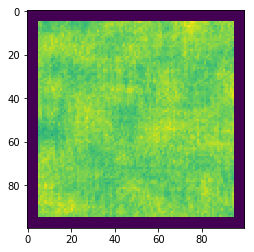

In [58]:
plt.imshow(res)

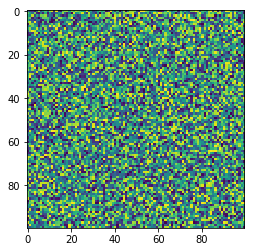

In [55]:
plt.imshow(image)

Numba can also compile for GPUs. See http://numba.pydata.org/numba-doc/0.37.0/cuda/index.html

<img src="http://pypy.org/image/pypy-logo.png">

Python interpreter and C/JIT compiler. See http://pypy.org/

*“If you want your code to run faster, you should probably just use PyPy.”*
   — Guido van Rossum (creator of Python)


# Breakout

a. Write a nested for loop that does elementwise array multiplication (on `A` and `B`) and prints the results. 

b. Get the runtime speed for A.shape = (30,50) and B.shape = (50,15)

c. Try using numba to make it faster.

d. How does the numba speed compare to the native matrix multiplication in numpy (`numpy.dot`)?

In [ ]:
%mem

## Ctypes ##

ctypes is a foreign function library for Python. It provides C compatible data types, and allows calling functions in DLLs or shared libraries. It can be used to wrap these libraries in pure Python.

https://docs.python.org/3/library/ctypes.html

In [82]:
from ctypes import *

In [83]:
p = create_string_buffer(b"Hello", 10)   # create a 10 byte buffer

In [84]:
p

In [85]:
p.value

b'Hello'

In [86]:
print(sizeof(p)) ; repr(p.raw)

10


"b'Hello\\x00\\x00\\x00\\x00\\x00'"

In [87]:
repr(p.raw)

"b'Hello\\x00\\x00\\x00\\x00\\x00'"

In [88]:
p.value = b"Bye."

In [89]:
print(sizeof(p)) ; repr(p.raw)

10


"b'Bye.\\x00\\x00\\x00\\x00\\x00\\x00'"

<table border="1" class="docutils">
<colgroup>
<col width="24%" />
<col width="46%" />
<col width="30%" />
</colgroup>
<thead valign="bottom">
<tr><th class="head">ctypes type</th>
<th class="head">C type</th>
<th class="head">Python type</th>
</tr>
</thead>
<tbody valign="top">
<tr><td><a class="reference internal" href="#ctypes.c_bool" title="ctypes.c_bool"><tt class="xref py py-class docutils literal"><span class="pre">c_bool</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">_Bool</span></tt></td>
<td>bool (1)</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_char" title="ctypes.c_char"><tt class="xref py py-class docutils literal"><span class="pre">c_char</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">char</span></tt></td>
<td>1-character string</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_wchar" title="ctypes.c_wchar"><tt class="xref py py-class docutils literal"><span class="pre">c_wchar</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">wchar_t</span></tt></td>
<td>1-character unicode string</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_byte" title="ctypes.c_byte"><tt class="xref py py-class docutils literal"><span class="pre">c_byte</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">char</span></tt></td>
<td>int/long</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_ubyte" title="ctypes.c_ubyte"><tt class="xref py py-class docutils literal"><span class="pre">c_ubyte</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">unsigned</span> <span class="pre">char</span></tt></td>
<td>int/long</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_short" title="ctypes.c_short"><tt class="xref py py-class docutils literal"><span class="pre">c_short</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">short</span></tt></td>
<td>int/long</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_ushort" title="ctypes.c_ushort"><tt class="xref py py-class docutils literal"><span class="pre">c_ushort</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">unsigned</span> <span class="pre">short</span></tt></td>
<td>int/long</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_int" title="ctypes.c_int"><tt class="xref py py-class docutils literal"><span class="pre">c_int</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">int</span></tt></td>
<td>int/long</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_uint" title="ctypes.c_uint"><tt class="xref py py-class docutils literal"><span class="pre">c_uint</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">unsigned</span> <span class="pre">int</span></tt></td>
<td>int/long</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_long" title="ctypes.c_long"><tt class="xref py py-class docutils literal"><span class="pre">c_long</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">long</span></tt></td>
<td>int/long</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_ulong" title="ctypes.c_ulong"><tt class="xref py py-class docutils literal"><span class="pre">c_ulong</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">unsigned</span> <span class="pre">long</span></tt></td>
<td>int/long</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_longlong" title="ctypes.c_longlong"><tt class="xref py py-class docutils literal"><span class="pre">c_longlong</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">__int64</span></tt> or <tt class="xref c c-type docutils literal"><span class="pre">long</span> <span class="pre">long</span></tt></td>
<td>int/long</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_ulonglong" title="ctypes.c_ulonglong"><tt class="xref py py-class docutils literal"><span class="pre">c_ulonglong</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">unsigned</span> <span class="pre">__int64</span></tt> or
<tt class="xref c c-type docutils literal"><span class="pre">unsigned</span> <span class="pre">long</span> <span class="pre">long</span></tt></td>
<td>int/long</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_float" title="ctypes.c_float"><tt class="xref py py-class docutils literal"><span class="pre">c_float</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">float</span></tt></td>
<td>float</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_double" title="ctypes.c_double"><tt class="xref py py-class docutils literal"><span class="pre">c_double</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">double</span></tt></td>
<td>float</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_longdouble" title="ctypes.c_longdouble"><tt class="xref py py-class docutils literal"><span class="pre">c_longdouble</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">long</span> <span class="pre">double</span></tt></td>
<td>float</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_char_p" title="ctypes.c_char_p"><tt class="xref py py-class docutils literal"><span class="pre">c_char_p</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">char</span> <span class="pre">*</span></tt> (NUL terminated)</td>
<td>string or <tt class="xref docutils literal"><span class="pre">None</span></tt></td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_wchar_p" title="ctypes.c_wchar_p"><tt class="xref py py-class docutils literal"><span class="pre">c_wchar_p</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">wchar_t</span> <span class="pre">*</span></tt> (NUL terminated)</td>
<td>unicode or <tt class="xref docutils literal"><span class="pre">None</span></tt></td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_void_p" title="ctypes.c_void_p"><tt class="xref py py-class docutils literal"><span class="pre">c_void_p</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">void</span> <span class="pre">*</span></tt></td>
<td>int/long or <tt class="xref docutils literal"><span class="pre">None</span></tt></td>
</tr>
</tbody>
</table>

In [90]:
x = c_int(100)

In [91]:
print(x)

c_int(100)


In [92]:
type(x.value)

int

In [93]:
sizeof(x)

4

In [94]:
y = 100

In [95]:
import sys
sys.getsizeof(y)

28

In [96]:
sys.getsizeof(x)

136

In [98]:
%%file test.c
#include <stdio.h>

void myprint(void);

void myprint()
{
    printf("hello world\n");
}

Overwriting test.c


In [99]:
!cat test.c

#include <stdio.h>

void myprint(void);

void myprint()
{
    printf("hello world\n");
}

In [100]:
# linux
#!gcc -shared -Wl,-soname,test -o test.so -fPIC test.c

# or... for Mac OS X 
!gcc -shared -Wl,-install_name,testlib.so -o test.so -fPIC test.c

In [101]:
!ls -lat |head

total 264
-rwxr-xr-x   1 jbloom  staff   8376 Apr 23 15:36 test.so
drwxr-xr-x  21 jbloom  staff    672 Apr 23 15:36 .
-rw-r--r--   1 jbloom  staff     88 Apr 23 15:36 test.c
drwxr-xr-x   6 jbloom  staff    192 Apr 23 14:38 __pycache__
-rw-r--r--   1 jbloom  staff    427 Apr 23 14:37 sometask.py
-rw-r--r--   1 jbloom  staff   7274 Apr 23 14:29 sometask.profile
drwxr-xr-x   3 jbloom  staff     96 Apr 22 16:52 pairwise_fort.cpython-36m-darwin.so.dSYM
-rwxr-xr-x   1 jbloom  staff  28444 Apr 22 16:52 pairwise_fort.cpython-36m-darwin.so
-rw-r--r--   1 jbloom  staff    533 Apr 22 16:50 pairwise_fort.f


In [102]:
%%file myctest.py
import ctypes
myctest = ctypes.CDLL('./test.so')
myctest.myprint()

Overwriting myctest.py


In [103]:
import ctypes
myctest = ctypes.CDLL('./test.so')
myctest.myprint()

12

In [104]:
%%file test1.c
int add(int a, int b);

int add(int a, int b)
{
    return(a+b);
}

Overwriting test1.c


In [105]:
!gcc -shared -Wl,-install_name,test1lib.so -o test1.so -fPIC test1.c

In [107]:
from ctypes import *

# load the shared object
libtest = cdll.LoadLibrary('./test1.so')

# call the function, yes it is as simple as that!
print(libtest.add(100, 10))

110


In [108]:
%timeit libtest.add(10,20)

304 ns ± 16.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [109]:
%timeit sum([10,20])

133 ns ± 0.735 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [ ]:
sum?

In [110]:
%timeit 10 + 20

12.4 ns ± 0.147 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


For a whole lot of timing comparisons, see 
http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/NumbaCython.ipynb

## f2py 

<pre>
...automatically construct an extension module that interfaces to routines in Fortran 77/90/95 code. It has the ability to parse Fortran 77/90/95 code and automatically generate Python signatures for the subroutines it encounters, or you can guide how the subroutine interfaces with Python by constructing an interface-definition-file (or modifying the f2py-produced one).
</pre>

It's part of numpy!

(http://docs.scipy.org/doc/numpy/user/c-info.python-as-glue.html#f2py)

In [111]:
%%file pairwise_fort.f

      subroutine pairwise_fort(X,D,m,n)
          integer :: n,m
          double precision, intent(in) :: X(m,n)
          double precision, intent(out) :: D(m,m) 
          integer :: i,j,k
          double precision :: r 
          do i = 1,m 
              do j = 1,m 
                  r = 0
                  do k = 1,n 
                      r = r + (X(i,k) - X(j,k)) * (X(i,k) - X(j,k)) 
                  end do 
                  D(i,j) = sqrt(r) 
              end do 
          end do 
      end subroutine pairwise_fort

Overwriting pairwise_fort.f


In [112]:
!f2py -c pairwise_fort.f -m pairwise_fort > /dev/null

In [117]:
import numpy as np
X = np.random.random((1000, 3))
from pairwise_fort import pairwise_fort
XF = np.asarray(X, order='C')
#%timeit pairwise_fort(XF)
print(XF)
print(np.asarray(X, order='F'))

[[0.89529798 0.89541847 0.72992756]
 [0.8747856  0.57895977 0.23215644]
 [0.19709393 0.31809993 0.69110304]
 ...
 [0.53956062 0.3500995  0.58760204]
 [0.52208119 0.79117662 0.03905269]
 [0.17798541 0.02048669 0.66846777]]
[[0.89529798 0.89541847 0.72992756]
 [0.8747856  0.57895977 0.23215644]
 [0.19709393 0.31809993 0.69110304]
 ...
 [0.53956062 0.3500995  0.58760204]
 [0.52208119 0.79117662 0.03905269]
 [0.17798541 0.02048669 0.66846777]]


In [114]:
!ls -lat | head

total 264
-rwxr-xr-x   1 jbloom  staff  28444 Apr 23 15:40 pairwise_fort.cpython-36m-darwin.so
drwxr-xr-x  21 jbloom  staff    672 Apr 23 15:40 .
-rw-r--r--   1 jbloom  staff    533 Apr 23 15:40 pairwise_fort.f
-rwxr-xr-x   1 jbloom  staff   4176 Apr 23 15:38 test1.so
-rw-r--r--   1 jbloom  staff     66 Apr 23 15:38 test1.c
-rw-r--r--   1 jbloom  staff     66 Apr 23 15:36 myctest.py
-rwxr-xr-x   1 jbloom  staff   8376 Apr 23 15:36 test.so
-rw-r--r--   1 jbloom  staff     88 Apr 23 15:36 test.c
drwxr-xr-x   6 jbloom  staff    192 Apr 23 14:38 __pycache__


# Breakout

a. Write a nested for loop that does elementwise array multiplication (on `A` and `B`) and prints the results. 

In [76]:
import numpy as np

def my_dot(A, B):
    assert len(A.shape) == 2
    assert len(B.shape) == 2
    assert A.shape[1] == B.shape[0]
    
    outarray = np.zeros((A.shape[0], B.shape[1]))
    for i in range(outarray.shape[0]):
        for j in range(outarray.shape[1]):
            for k in range(B.shape[0]):
                outarray[i,j]  += A[i,k]*B[k,j]
    
    return outarray

b. Get the runtime speed for A.shape = (30,50) and B.shape = (50,15)

In [77]:
A = np.ones((30,50))
B = np.ones((50,15))

rez = my_dot(A, B)

np.alltrue(A.dot(B) == rez)

True

In [78]:
%timeit my_dot(A, B)

11.7 ms ± 79 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


c. Try using numba to make it faster.

In [79]:
from numba import double, jit

numbamy_dot = jit(double[:,:](double[:,:], double[:,:]))(my_dot)

In [80]:
%timeit numbamy_dot(A, B)

19.8 µs ± 119 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


d. How does the numba speed compare to the native matrix multiplication in numpy (`numpy.dot`)?

In [81]:
%timeit A.dot(B)

5.25 µs ± 38 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
